# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Описание данных
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

In [2]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy.random import RandomState
from scipy import stats as st
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



random = 12345
state = RandomState(random) 

In [22]:
BUDGET = 10*(10**9)
MAX_POINTS = 500
FINAL_POINTS = 200
PRICE_PER_BARREL = 450_000
DAMAGE_THRESHOLD = 0.025

Ввели константы для рассчета точки безубыточности.

In [4]:
df_1 = pd.read_csv("/datasets/geo_data_0.csv")
df_2 = pd.read_csv("/datasets/geo_data_1.csv")
df_3 = pd.read_csv("/datasets/geo_data_2.csv")

In [5]:
def display_frames(frames):
    for frame in frames:        
        display(frame)
        print()

Создадим функцию для удобства вывода датафреймов

In [6]:
display_frames([df_1.info(), df_2.info(), df_3.info()])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null 

None

None

None

Видим, что пропусков нет, типы у столбцов правильные.

In [7]:
print('Количество дубликатов в первой таблице: ', df_1.duplicated().sum())
print('Количество дубликатов во второй таблице: ', df_2.duplicated().sum())
print('Количество дубликатов в третьей таблице: ', df_3.duplicated().sum())

Количество дубликатов в первой таблице:  0
Количество дубликатов во второй таблице:  0
Количество дубликатов в третьей таблице:  0


Дубликаты так же отсутствуют. Изучим информацию о значениях.

In [8]:
display_frames([df_1.describe(), df_2.describe(), df_3.describe()])

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Визулизируем полученные данные.

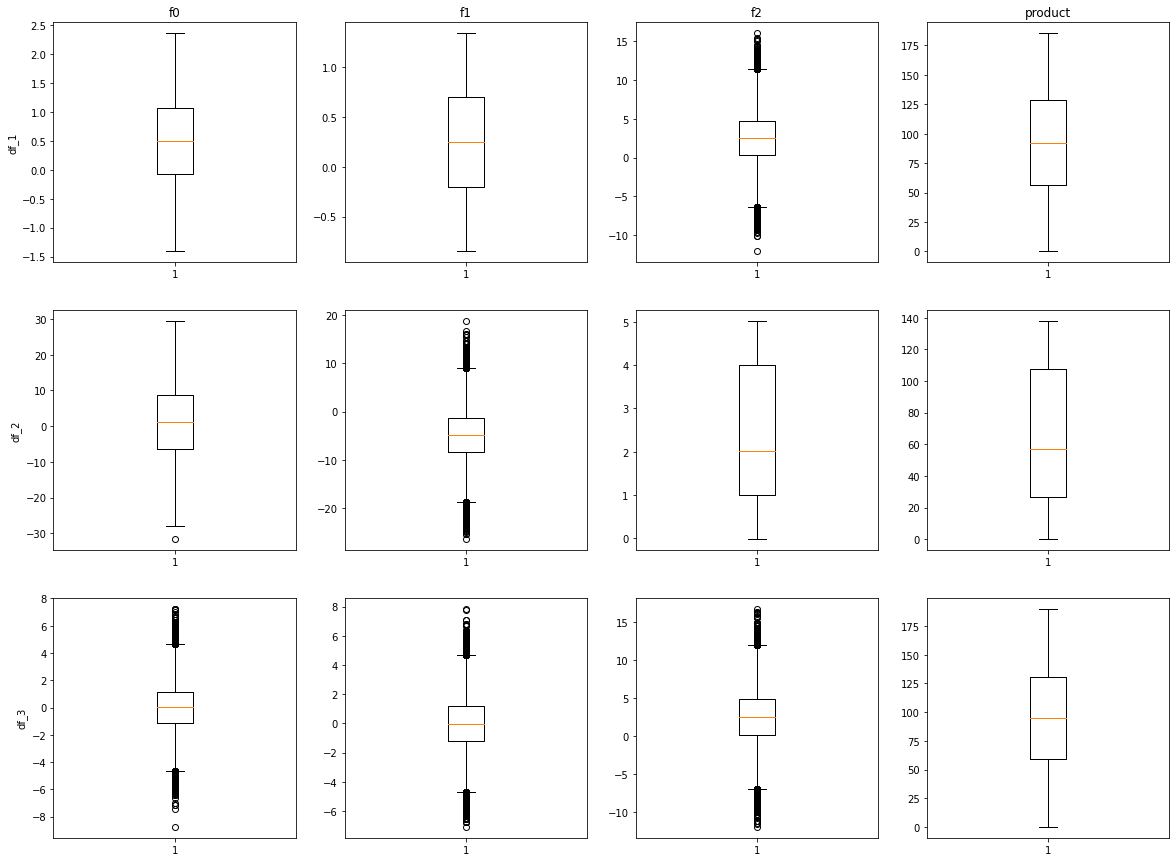

In [9]:
fig,ax = plt.subplots(3,4,figsize = (20,15))

all_frames = ["df_1","df_2","df_3"]
num_columns = df_1.columns[1:]
num_columns_with_columns = zip(df_1.columns[1:],range(4))
all_frames_with_rows = zip([df_1, df_2, df_3],range(3))
# Построим графики
for column in list(itertools.product(all_frames_with_rows,num_columns_with_columns)):
    ax[column[0][1]][column[1][1]].boxplot(column[0][0][column[1][0]])
# Добавим название фрейма изображаемого на графике
for row in range(3):
    ax[row][0].set_ylabel(all_frames[row])
# Добавим название столбца изображаемого на графике
for column in range(4):
    ax[0][column].set_title(num_columns[column])

Можем наблюдать выбросы, в обычной ситуации мы бы от них избавились, однако отсутствие подробной информации о признаках не позволяет понять экстремальные значения это или выбросы, поэтому оставим их.

Теперь проверим признаки на корреляцию.

In [10]:
display_frames([df_1.corr(), df_2.corr(), df_3.corr()])

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


Видим сильной корреляции признаков между собой.

## Обучение и проверка модели

In [11]:
array_name = ['df_1', 'df_2', 'df_3']
array_frame = [df_1, df_2, df_3]

data_dict = {'model':{}, 'valid':{}, 'scores':{}}

for frame, name in zip(array_frame, array_name):
    features = frame.drop(['id','product'], axis=1)
    target = frame['product']
    (features_train, features_valid, target_train, target_valid) = train_test_split(
        features, target,test_size = 0.25, random_state = random)
    model = LinearRegression()
    
    data_dict['valid'][name] = (features_valid, target_valid)
    model.fit(features_train, target_train)
    pred = model.predict(features_valid)
    data_dict['model'][name] = model
    data_dict['scores'][name] = (mean_squared_error(target_valid, pred))**0.5

In [12]:
data_dict['scores']

{'df_1': 37.5794217150813,
 'df_2': 0.893099286775617,
 'df_3': 40.02970873393434}

Получились выборки с минимальной ошибкой. Второй регион пока показывает лучшие результаты.

In [13]:
predicted_df_1 = data_dict['model']['df_1'].predict(data_dict['valid']['df_1'][0])
predicted_df_2 = data_dict['model']['df_2'].predict(data_dict['valid']['df_2'][0])
predicted_df_3 = data_dict['model']['df_3'].predict(data_dict['valid']['df_3'][0])


RMSE_model_1 = (mean_squared_error(data_dict['valid']['df_1'][1],predicted_df_1))**0.5
RMSE_model_2 = (mean_squared_error(data_dict['valid']['df_2'][1],predicted_df_2))**0.5
RMSE_model_3 = (mean_squared_error(data_dict['valid']['df_3'][1],predicted_df_3))**0.5

In [14]:
print('Первый датафрейм')
print("Средний запас:", predicted_df_1.mean())
print('RMSE модели:',RMSE_model_1)
print()

print('Второй датафрейм')
print("Средний запас:", predicted_df_2.mean())
print('RMSE модели:',RMSE_model_2)
print()

print('Третий датафрейм')
print("Средний запас:", predicted_df_3.mean())
print('RMSE модели:',RMSE_model_3)
print()

Первый датафрейм
Средний запас: 92.59256778438035
RMSE модели: 37.5794217150813

Второй датафрейм
Средний запас: 68.728546895446
RMSE модели: 0.893099286775617

Третий датафрейм
Средний запас: 94.96504596800489
RMSE модели: 40.02970873393434



Выводы:
- Первый регион:
    - Ошибка в нем на втором месте, как и по среднему объему запасов.
- Второй регион:
    - Имеет самую маленькую ошибку, однако показывает объемы сильно меньше, чем в других регионах
- Третий регион: 
    - Самый большой средний объем запасов, но по ошибке регион на втором месте

## Подготовка к расчёту прибыли

In [15]:
profit_point = BUDGET/(PRICE_PER_BARREL*FINAL_POINTS)
print("Достаточный объем добычи для безубыточной разработки",round(profit_point,2))

Достаточный объем добычи для безубыточной разработки 111.11


In [16]:
display_frames([df_1['product'].describe(), df_2['product'].describe(), df_3['product'].describe()])

count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product, dtype: float64

count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64

count    100000.000000
mean         95.000000
std          44.749921
min           0.000000
25%          59.450441
50%          94.925613
75%         130.595027
max         190.029838
Name: product, dtype: float64

В соотвествии с найденным значением безубыточности, все регионы нам подходят.

In [17]:
print("35% скважин в нулевом регионе содержат больше сырья, чем ",
      round(df_1["product"].quantile(0.65),2))
print("16% скважин в нулевом регионе содержат больше сырья, чем ",
      round(df_2["product"].quantile(0.84),2))
print("35% скважин в нулевом регионе содержат больше сырья, чем ",
      round(df_3["product"].quantile(0.65),2))

35% скважин в нулевом регионе содержат больше сырья, чем  113.17
16% скважин в нулевом регионе содержат больше сырья, чем  134.77
35% скважин в нулевом регионе содержат больше сырья, чем  115.71


Минимальное количество баррелей нефти для безубыточной разработки составило 111.(1)

В тоже время максимальное средний объем в регионах равен 94. Если обратить внимание на значения районов выше данного значения, что в нулевом и втором районах 35% скважин проходят минимальный порог

В то время как в первом районе подходят только 16% скважин

## Расчёт прибыли и рисков 

In [18]:
def income(target, pred):
    sort_series = pd.Series(pred).sort_values(ascending=False)[:FINAL_POINTS]
    
    sort_target = target.reset_index(drop=True)[sort_series.index]
    
    sum_ = sort_target.sum()
    
    return round(((PRICE_PER_BARREL*sum_) - BUDGET),2)


In [19]:
print("Прибыль с лучших 200 скважин в первом регионе:",income(data_dict['valid']['df_1'][1],
                                                               predicted_df_1))
print("Прибыль с лучших 200 скважин во втором регионе:",income(data_dict['valid']['df_2'][1],
                                                               predicted_df_2))
print("Прибыль с лучших 200 скважин в третьем регионе:",income(data_dict['valid']['df_3'][1],
                                                               predicted_df_3))

Прибыль с лучших 200 скважин в первом регионе: 3320826043.14
Прибыль с лучших 200 скважин во втором регионе: 2415086696.68
Прибыль с лучших 200 скважин в третьем регионе: 2710349963.6


In [20]:
def confidence_check(target, pred):
    samples = []
    for i in range(1000):
        sample = pd.Series(pred).sample(n = 500, replace=True, random_state=state)
        samples.append(income(target, sample))
    samples = pd.Series(samples)
    #print(samples.apply(samples[samples < 0].sum()/len(samples)*100),'%')
    print("Риск убытков", (samples < 0).mean()*100,"%")
    
    print('Среднее', samples.mean())
    
    lower = samples.quantile(0.025)
    upper = samples.quantile(0.975)
    return round(lower,2), round(upper,2)

In [25]:
print('Первый регион')
print('Доверительный интервал', confidence_check(data_dict['valid']['df_1'][1],pd.Series(predicted_df_1)))
print()

print('Второй регион')
print('Доверительный интервал', confidence_check(data_dict['valid']['df_2'][1],pd.Series(predicted_df_2)))
print()

print('Третий регион')
print('Доверительный интервал', confidence_check(data_dict['valid']['df_3'][1],pd.Series(predicted_df_3)))
print()

Первый регион
Риск убытков 6.800000000000001 %
Среднее 390966231.18815005
Доверительный интервал (-131142419.82, 894590067.66)

Второй регион
Риск убытков 0.8 %
Среднее 453610604.31722003
Доверительный интервал (65250085.09, 848725403.42)

Третий регион
Риск убытков 7.000000000000001 %
Среднее 399976407.20425
Доверительный интервал (-105397570.13, 943629031.71)



## Вывод

- Первый регион:
    - Доверительный интервал: (-131 142 419.82, 894 590 067.66)
    - Точка безубыточности: 111.1
    - Средняя прибыль в нулевом регионе: 390 966 231.18
    - Риски: 6.8 %
- Второй регион:
    - Доверительный интервал: (65 250 085.09, 848 725 403.42)
    - Точка безубыточности: 111.1
    - Средняя прибыль с одной скважины во втором регионе: 453 610 604.31
    - Риски: 0.8 %
- Третий регион:
    - Доверительный интервал: (-105 397 570.13, 943 629 031.71)
    - Точка безубыточности: 111.1
    - Средняя прибыль в нулевом регионе: 399 976 407.2
    - Риски: 7 %    

По условиям рисков нам подходит второй регион, в нем риски < 1 %, т.к. другие регионы имеют большие риски, следует порекоммендовать выбрать его.